In [15]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [16]:
df = pd.read_csv('df_scaled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   povertyPercentage          187534 non-null  float64
 1   incident_gravity           187534 non-null  float64
 2   females_rate               187534 non-null  float64
 3   minor_rate                 187534 non-null  float64
 4   arrested_rate              187534 non-null  float64
 5   survival_rate              187534 non-null  float64
 6   winning_party_percentage   187534 non-null  float64
 7   killed_rate                187534 non-null  float64
 8   injured_rate               187534 non-null  float64
 9   killed_disp_per_district   187534 non-null  float64
 10  injured_disp_per_district  187534 non-null  float64
 11  part_disp_per_district     187534 non-null  float64
 12  avg_age_participants       187534 non-null  float64
 13  n_participants             18

In [17]:
df['state'].value_counts()

state
illinois          15319
california        12980
florida           11972
texas             10453
new york           8449
ohio               8137
georgia            7300
pennsylvania       7142
north carolina     6874
louisiana          6345
tennessee          5931
missouri           5784
south carolina     5604
massachusetts      4969
virginia           4576
indiana            4560
michigan           4544
new jersey         4530
maryland           4266
alabama            4117
wisconsin          3969
kentucky           3260
oklahoma           2906
mississippi        2777
washington         2735
colorado           2654
connecticut        2599
arkansas           2337
iowa               2238
oregon             1884
arizona            1861
kansas             1829
minnesota          1715
nevada             1502
new mexico         1406
nebraska           1318
west virginia      1215
alaska             1215
utah                872
new hampshire       821
maine               802
rhode isla

We selected one state as stated in subtask of clustering task.

In particular, we decided to select the state with the second higher number of gun incidents which resulted California

In [18]:
df = df.loc[df['state'] == 'california']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12980 entries, 7720 to 174920
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   povertyPercentage          12980 non-null  float64
 1   incident_gravity           12980 non-null  float64
 2   females_rate               12980 non-null  float64
 3   minor_rate                 12980 non-null  float64
 4   arrested_rate              12980 non-null  float64
 5   survival_rate              12980 non-null  float64
 6   winning_party_percentage   12980 non-null  float64
 7   killed_rate                12980 non-null  float64
 8   injured_rate               12980 non-null  float64
 9   killed_disp_per_district   12980 non-null  float64
 10  injured_disp_per_district  12980 non-null  float64
 11  part_disp_per_district     12980 non-null  float64
 12  avg_age_participants       12980 non-null  float64
 13  n_participants             12980 non-null  floa

In [19]:
column_to_drop = ['avg_age_participants','n_participants','n_participants_child', 'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed','date', 'latitude', 'longitude','congressional_district', 'candidatevotes', 'totalvotes', 'involve_killing', 'involve_injury', 'involve_arrest','is_survived','pc1', 'pc2']

       
for col in df.columns:
    if df[col].dtype == 'object':
       column_to_drop.append(col)
column_to_drop

['avg_age_participants',
 'n_participants',
 'n_participants_child',
 'n_participants_teen',
 'n_females',
 'n_killed',
 'n_injured',
 'n_arrested',
 'n_unharmed',
 'date',
 'latitude',
 'longitude',
 'congressional_district',
 'candidatevotes',
 'totalvotes',
 'involve_killing',
 'involve_injury',
 'involve_arrest',
 'is_survived',
 'pc1',
 'pc2',
 'date',
 'state',
 'city_or_county',
 'incident_characteristics1',
 'party']

In [20]:
df_categorical = df[column_to_drop]
df_numeric = df.drop(columns=column_to_drop)

In [21]:
df_categorical.info()
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12980 entries, 7720 to 174920
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   avg_age_participants       12980 non-null  float64
 1   n_participants             12980 non-null  float64
 2   n_participants_child       12980 non-null  int64  
 3   n_participants_teen        12980 non-null  int64  
 4   n_females                  12980 non-null  float64
 5   n_killed                   12980 non-null  float64
 6   n_injured                  12980 non-null  float64
 7   n_arrested                 12980 non-null  float64
 8   n_unharmed                 12980 non-null  float64
 9   date                       12980 non-null  object 
 10  latitude                   12980 non-null  float64
 11  longitude                  12980 non-null  float64
 12  congressional_district     12980 non-null  int64  
 13  candidatevotes             12980 non-null  int6

# Hierarchical clustering (Agglomerative)

In [22]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn import metrics

In [23]:
table = []
for metric in ['cityblock','correlation', 'cosine', 'euclidean']:
    methods = ['complete','single','average','weighted']
    if metric == 'euclidean':
        methods += ['ward','median','centroid']
    for method in methods:
        for truncation_mode in [None, 'lastp','level']:
            for level in [2,5,15]:
                for k in [5, 10]:
                    distances = pdist(df_numeric, metric=metric)
                    dlinkage = linkage(distances, metric=metric, method=method)
                    labels = fcluster(dlinkage,k,criterion='maxclust')
                    current_silhouette = silhouette_score(df_numeric, labels)
                    current_bouldin = metrics.davies_bouldin_score(df_numeric, labels)
                    print(f"metric: {metric}, method:{method}, truncation_mode:{truncation_mode}, level':{level}, k:{k}, silhouette: {current_silhouette} , DBscore:{current_bouldin}")
                    #dendrogram(dlinkage, truncate_mode=truncation_mode, p=level, leaf_rotation=90)
                    plt.show()
                    table.append({'metric':metric, 'method':method, 'truncation_mode': truncation_mode, 'level':level, 'k':k, 'silhouette': current_silhouette, 'DBscore':current_bouldin})

df_table = pd.DataFrame(table)

metric: cityblock, method:complete, truncation_mode:None, level':2, k:5, silhouette: 0.2956507564819501 , DBscore:0.7410252715340289
metric: cityblock, method:complete, truncation_mode:None, level':2, k:10, silhouette: 0.2071123547933502 , DBscore:1.2734375686808517
metric: cityblock, method:complete, truncation_mode:None, level':5, k:5, silhouette: 0.2956507564819501 , DBscore:0.7410252715340289
metric: cityblock, method:complete, truncation_mode:None, level':5, k:10, silhouette: 0.2071123547933502 , DBscore:1.2734375686808517
metric: cityblock, method:complete, truncation_mode:None, level':15, k:5, silhouette: 0.2956507564819501 , DBscore:0.7410252715340289
metric: cityblock, method:complete, truncation_mode:None, level':15, k:10, silhouette: 0.2071123547933502 , DBscore:1.2734375686808517
metric: cityblock, method:complete, truncation_mode:lastp, level':2, k:5, silhouette: 0.2956507564819501 , DBscore:0.7410252715340289
metric: cityblock, method:complete, truncation_mode:lastp, leve

Retraining the best Hierachical clustering found    

metric: correlation, method:weighted, truncation_mode:level, level':5, k:5, silhouette: 0.2589355057625014 , DBscore:1.4509696821004128


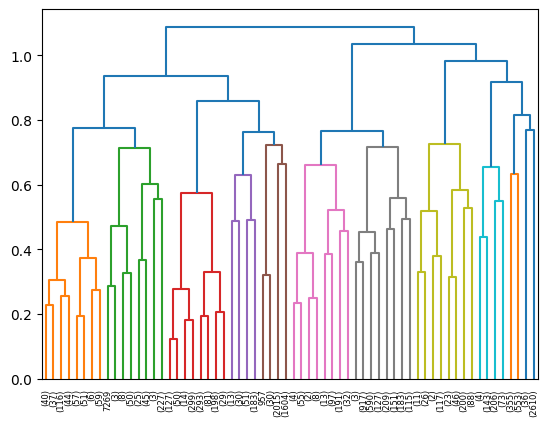

In [24]:
table = []
metric = "correlation"
method = "weighted"
truncation_mode = "level"
level = 5
k = 5

#metric: cosine, method:average, truncation_mode:level, level':5, k:5, silhouette: 0.27780283088250923 , DBscore:1.1667198461283845

distances = pdist(df_numeric, metric=metric)
dlinkage = linkage(distances, metric=metric, method=method)
clusters = fcluster(dlinkage,k,criterion='maxclust')
current_silhouette = silhouette_score(df_numeric, clusters)
current_bouldin = metrics.davies_bouldin_score(df_numeric, clusters)
print(f"metric: {metric}, method:{method}, truncation_mode:{truncation_mode}, level':{level}, k:{k}, silhouette: {current_silhouette} , DBscore:{current_bouldin}")
dendrogram(dlinkage, truncate_mode=truncation_mode, p=level, leaf_rotation=90)
plt.show()
table.append({'metric':metric, 'method':method, 'truncation_mode': truncation_mode, 'level':level, 'k':k, 'silhouette': current_silhouette, 'DBscore':current_bouldin})


Final Model

In [25]:
n_clusters = len(np.unique(clusters))
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(1, n_clusters + 1):
    occ_list.append(np.count_nonzero(np.array(clusters) == k))

print('cluster sizes:', occ_list)

cluster sizes: [772, 5018, 2697, 513, 3980]


Plot of cluster labels distribution

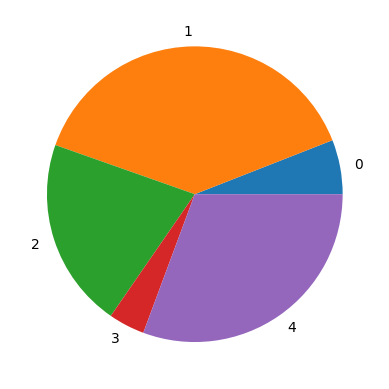

In [26]:
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

We can see from distribution that the number of records are not really well distributed, we will probably test more and see what happens later.

Involve_killing or not distribution

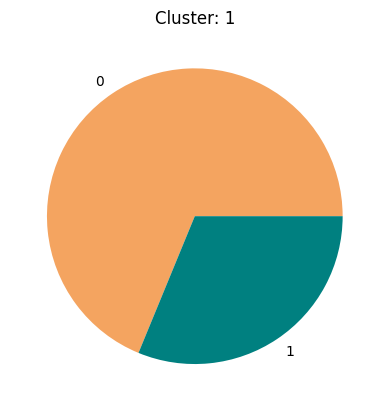

involve_killing
0    531
1    241
Name: count, dtype: int64


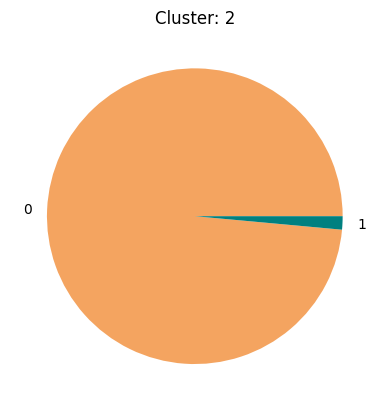

involve_killing
0    4945
1      73
Name: count, dtype: int64


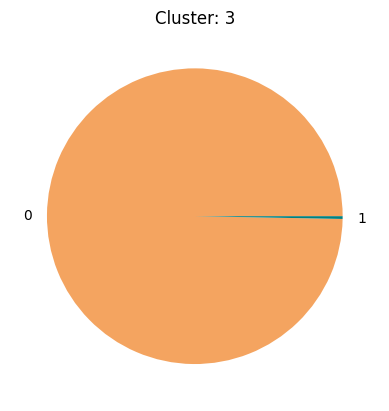

involve_killing
0    2689
1       8
Name: count, dtype: int64


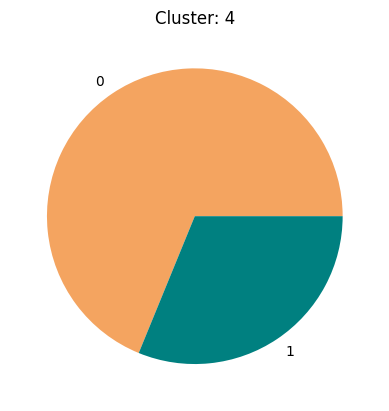

involve_killing
0    353
1    160
Name: count, dtype: int64


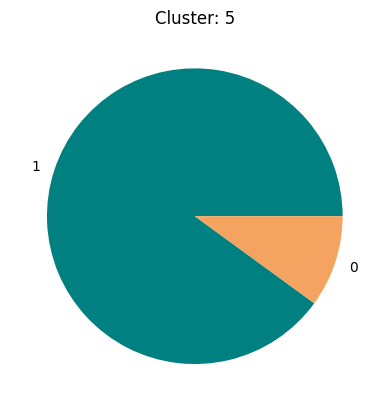

involve_killing
1    3581
0     399
Name: count, dtype: int64


In [27]:
dict_colors_involve_killing = { 1: 'teal', 0: 'sandybrown'}

for k in range(1, n_clusters + 1):
    # Get 'bot' values for elems in cluster k
    killing_for_clust = df_categorical['involve_killing'].loc[np.array(clusters) == k].value_counts()
    # Show pie plot
    labels_class = ['not-killed', 'killed']
    plt.title('Cluster: ' + str(k))
    plt.pie(killing_for_clust, labels= killing_for_clust.index, colors=[dict_colors_involve_killing[v] for v in killing_for_clust.keys()])
    plt.show()
    print(killing_for_clust)